# NBA Regular Season Performance, Postseason Performance, and City GDP

## Project Description

When looking at successful NBA teams, bigger-market teams seem to be more successful than small-market teams. For instance the Los Angeles Lakers and the Boston Celtics are both big market teams that have seen a lot of success in the past. This analysis will determine whether or not there is a statistical relationship between a city’s GDP, and the performance (both regular season and postseason) of the city’s NBA team. This is primarily a project to demonstrate data wrangling skills, specifically proficiency with Python and SQL. Less emphasis has been placed on the analysis and the results of the project.

# Description of Datasources

### Regular Season Data

The first set of dataset is basketball-reference.com’s [regular season team rating pages](https://www.basketball-reference.com/leagues/NBA_2010_ratings.html). I downloaded a different table for each season. Here is a screenshot of the table for the 2009-2010 season:

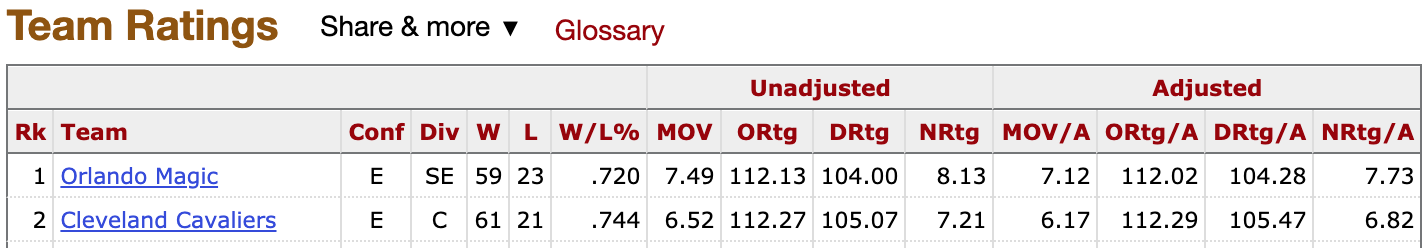

### Postseason Data

The second dataset is basketball-reference.com’s [postseason stats](https://www.basketball-reference.com/playoffs/NBA_2010.html#all_misc). There are numerous tables on this page, and the Miscellaneous Stats table was chosen because it shows W/L%. This allows for the comparison performance between regular season and postseason. Here is a screenshot of the 2010 postseason data:

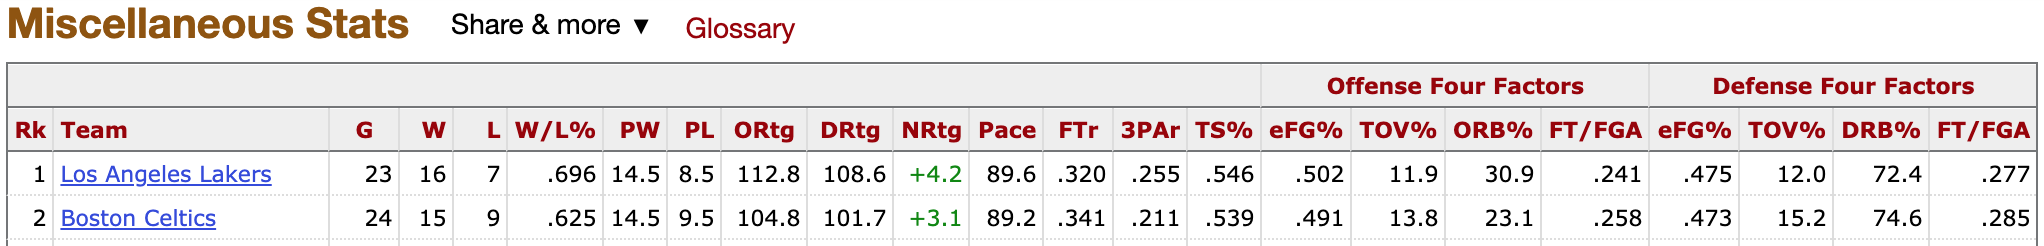

### US GDP Data

The third datasource is [US census data](https://drive.google.com/file/d/1t10jutYFxF5AeDpgggvCw7dHd4RL9xz9/view) showing GDP by US metro area from 2008-2018. Here is a screenshot of the data:

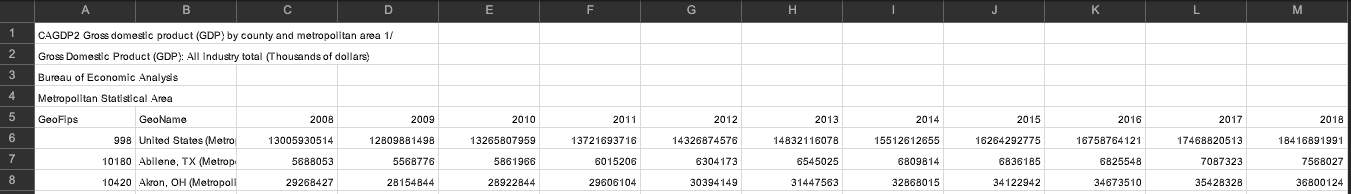

### Toronto GDP Data

The fourth datasource is [Toronto GDP data](https://www150.statcan.gc.ca/t1/tbl1/en/cv!recreate.action?pid=3610046801&selectedNodeIds=1D26&checkedLevels=&refPeriods=20090101,20160101&dimensionLayouts=layout3,layout2&vectorDisplay=false) from 2009-2016. The online table has been customized to ensure consistent formatting with the US census data above. Given the limitations of the Canadian dataset, there is only complete data from 2009-2016. Therefore, I will analyze team performance from the following seven seasons: 2009-2010, 2010-2011, 2011-2012, 2012-2013, 2013-2014, 2014-2015, 2015-2016. For the purposes of this project I will not be converting CAD to USD, given the additional complexity that that would require. This is a limitation of this analysis. Here is a screenshot of the exported CSV:

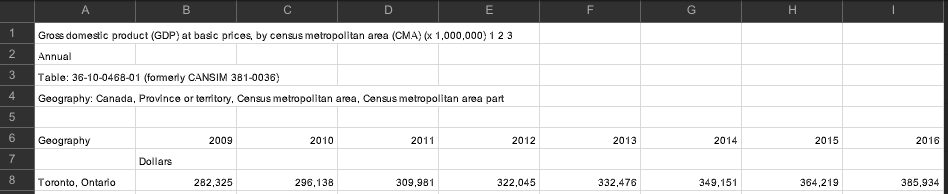

### NBA Teams

The final datasource is a list of all past and present [NBA and ABA teams](https://www.basketball-reference.com/teams/) from basketball-reference.com. A screenshot of the table on their website is below:

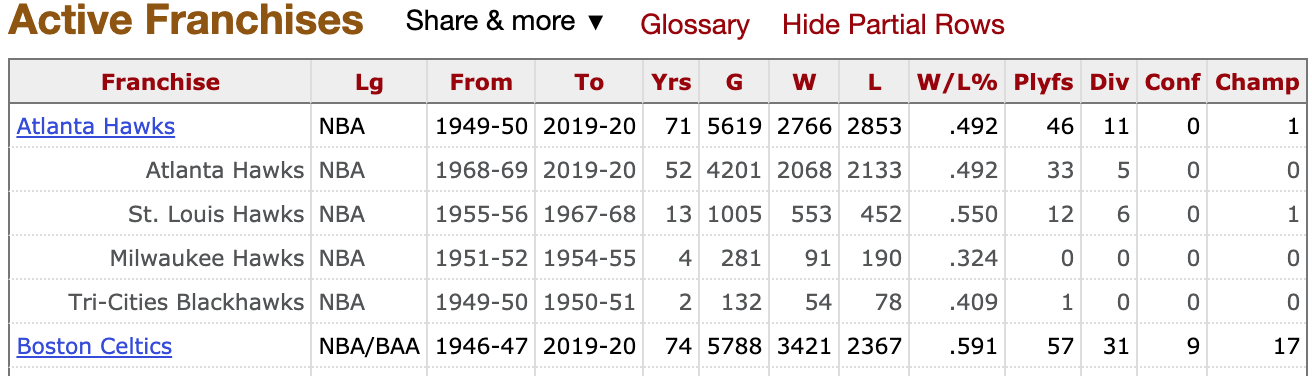

# Workflow Diagram

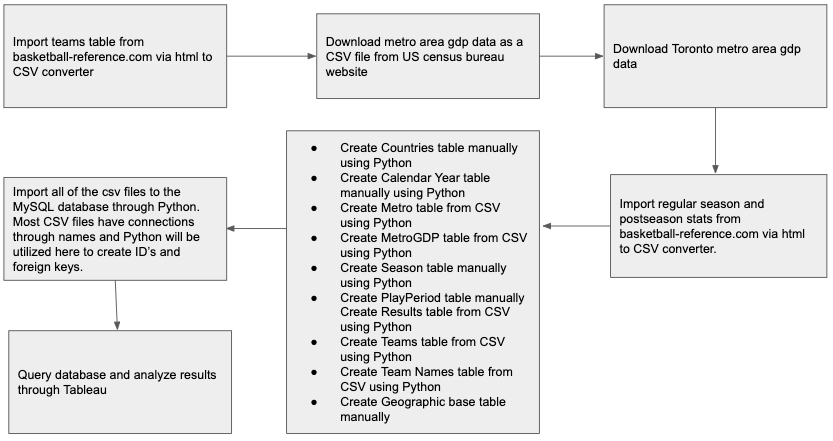

# Database Design

## Entity Relationship Diagram

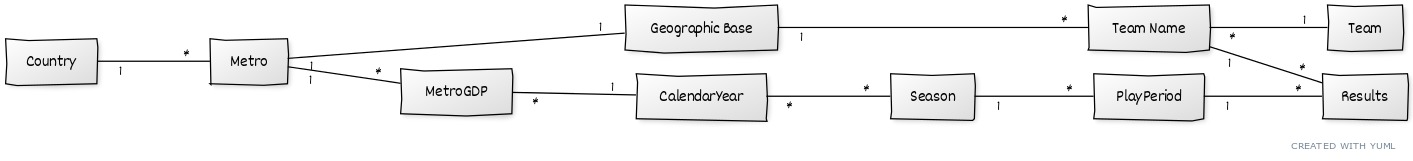

## Relational Vocabulary

## Table Sketches

### countries

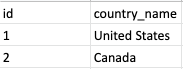

### metros

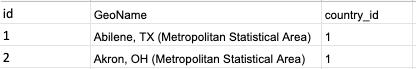

### gross_domestic_products

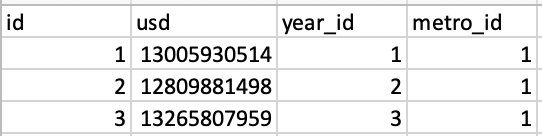

### calendar_years

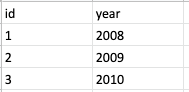

### seasons

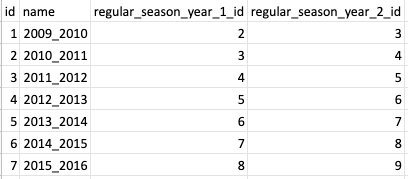

### play_periods

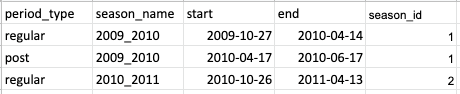

### results

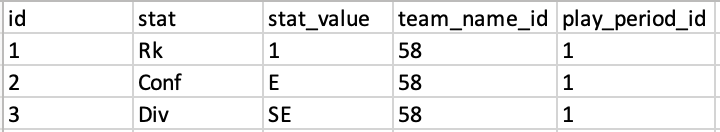

### team_names

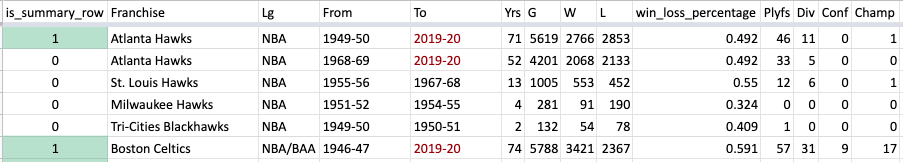

### geographic_base

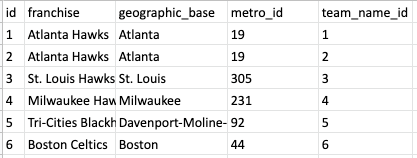

# Data Wrangling and Database Creation

The headings in this section correspond to entities from the entity relationship diagram. The entities are listed first by entities with no foreign keys, and then ordered as necessary to create foreign keys based on the database design. This order ensures that all databases are correctly created when all of the code is run from top to bottom.

## Final Database Schema

To recreate the database, manually create a new database called "final_project_nba_analysis". Then, run the SQL code below to recreate all of the tables.

## Creating The Database Connection

In [1]:
import pymysql.cursors

# This is the database connection from my data wrangling course. 
connection = pymysql.connect(
            host="mariadb",
            user="root",  # mysql user
            passwd="",  # mysql passd
            db="final_project_nba_analysis",
            autocommit=True,
            cursorclass=pymysql.cursors.DictCursor
            )

## Country

There are only two countries in this analysis (US and Canada) so this table will be created manually to list each country and the primary key. It will be made as a list of dictionaries to be consistent with the structure of the other tables.

In [2]:
countries = [
    {'name':'The United States of America'},
    {'name':'Canada'}
]

with connection.cursor() as cursor:
    sql = """INSERT INTO countries(name)
                VALUE (%(name)s)"""
    for country in countries:       
        cursor.execute(sql, country)

## CalendarYear

This table lists each calendar year, and was automatically created using a range of integers.

In [3]:
sql_insert_calendar_year = """INSERT INTO calendar_years(year) VALUE(%s)"""

with connection.cursor() as cursor:
    for year in range(2008, 2021):
        cursor.execute(sql_insert_calendar_year, year)

## Metro

In [3]:
import csv 

sql_insert_metro = """INSERT INTO metros(name, country_id)
                    VALUE (%(name)s, %(country_id)s)"""

# US data
with open('GDP_all_areas_2008-2018.csv') as f:
    csvfile = f.readlines()[4:390] # First 4 rows and last few rows are description
    # All of this file is United States data so fetch USA country id from the countries table
    sql_select_united_states_id = """SELECT id FROM countries WHERE name = 'The United States of America'"""
    myCSVReader = csv.DictReader(csvfile, delimiter=",", quotechar='"')
    with connection.cursor() as cursor:
        cursor.execute(sql_select_united_states_id)
        results = cursor.fetchone()
        for row in myCSVReader:
            metro_row = {}
            metro_row["country_id"] = results["id"]
            metro_row["name"] = row["GeoName"]
            cursor.execute(sql_insert_metro, metro_row)


NameError: name 'connection' is not defined

In [5]:
import csv

# Toronto data
with open('Toronto_CAD_GDP_2009_2016.csv') as f:
    csvfile = f.readlines()[5:8] # First 4 rows and last few rows are description
    # This is a single line of data about Toronto
    sql_select_canada_id = """SELECT id FROM countries WHERE name = 'Canada'"""
    myCSVReader = csv.DictReader(csvfile, delimiter=",", quotechar='"')
    next(myCSVReader) # Skip one row where it specifies the currency
    with connection.cursor() as cursor:
        cursor.execute(sql_select_canada_id)
        results = cursor.fetchone()
        for row in myCSVReader:
            metro_row = {}
            metro_row["country_id"] = results["id"]
            metro_row["name"] = row["Geography"]
            cursor.execute(sql_insert_metro, metro_row)

## MetroGDP

In [6]:
import csv 

sql_insert_gdp = """INSERT INTO gross_domestic_products(usd, year_id, metro_id)
                    VALUE (%(usd)s, %(year_id)s, %(metro_id)s)"""

sql_select_year_id = """SELECT id FROM calendar_years WHERE year = %s"""
sql_select_metro_id = """SELECT id FROM metros WHERE name = %s"""


# US data
with open('GDP_all_areas_2008-2018.csv') as f:
    csvfile = f.readlines()[4:390] # First 4 rows and last few rows are description
    # All of this file is United States data so fetch USA country id from the countries table
    myCSVReader = csv.DictReader(csvfile, delimiter=",", quotechar='"')
    with connection.cursor() as cursor:
        for row in myCSVReader:
            metro_name = row["GeoName"]
            with connection.cursor() as cursor:
                cursor.execute(sql_select_metro_id, metro_name)
                results = cursor.fetchone()
                metro_id = results["id"]
                # Remove the GeoFips and GeoName keys from dictionary so all of the remaning keys are years
                row.pop('GeoFips', None)
                row.pop('GeoName', None)
                for key in row:
                    cursor.execute(sql_select_year_id, key)
                    results = cursor.fetchone()
                    year_id = results["id"]
                    gdp_row = {}
                    gdp_row["usd"] = row[key]
                    gdp_row["year_id"] = year_id
                    gdp_row["metro_id"] = metro_id
                    cursor.execute(sql_insert_gdp, gdp_row)

In [7]:
# Toronto GDP
with open('Toronto_CAD_GDP_2009_2016.csv') as f:
    csvfile = f.readlines()[5:8] # First 4 rows and last few rows are description
    myCSVReader = csv.DictReader(csvfile, delimiter=",", quotechar='"')
    next(myCSVReader) # Skip one row where it specifies the currency
    with connection.cursor() as cursor:
        for row in myCSVReader:
            metro_name = row["Geography"]
            with connection.cursor() as cursor:
                cursor.execute(sql_select_metro_id, metro_name)
                results = cursor.fetchone()
                metro_id = results["id"]
                # Remove the Geography key from dictionary so all of the remaning keys are years
                row.pop('Geography', None)
                for key in row:
                    cursor.execute(sql_select_year_id, key)
                    results = cursor.fetchone()
                    year_id = results["id"]
                    gdp_row = {}
                    gdp_row["usd"] = int(row[key].replace(',', '')) # Remove the commas from the USD value
                    gdp_row["year_id"] = year_id
                    gdp_row["metro_id"] = metro_id
                    cursor.execute(sql_insert_gdp, gdp_row)

## Season

A table was manually created to give each season a name and include the calendar years associated with that season. The table was imported into the database.

In [8]:
# Postseason year is not included because it's always the second year of the regular season

# Creating seasons between 2009 - 2016
seasons = []
for year in range(2009, 2016):
    seasons.append({"name" : f'{year}_{year+1}'})
    
    
sql_insert_seasons = """INSERT INTO seasons(name, regular_season_year_1_id, regular_season_year_2_id) 
                         VALUE (%(name)s, %(regular_season_year_1_id)s, %(regular_season_year_2_id)s)"""

sql_select_calendar_year_id = """SELECT id FROM calendar_years WHERE year = %s"""

with connection.cursor() as cursor:
    for row in seasons:
        # finding foreign key for first year
        cursor.execute(sql_select_calendar_year_id, row["name"].split('_')[0])
        results = cursor.fetchone()
        row["regular_season_year_1_id"] = results["id"]

        # finding second foreign key
        cursor.execute(sql_select_calendar_year_id, row["name"].split('_')[1])
        results = cursor.fetchone()
        row["regular_season_year_2_id"] = results["id"]

        cursor.execute(sql_insert_seasons, row)


## PlayPeriod

This table breaks out the regular season and postseasons for each NBA season. Given that the start and end dates for each NBA season had to be manually researched online and manually entered, this table was created manually in excel and saved as a CSV. It has been uploaded below.

In [9]:
import csv

sql_insert_play_period = """INSERT INTO play_periods(season_name, period_type, start, end, season_id) 
                         VALUE (%(season_name)s, %(period_type)s, %(start)s, %(end)s, %(season_id)s)"""

sql_select_season_id = """SELECT id FROM seasons WHERE name = %(season_name)s"""

cursor = connection.cursor()

with open('play_periods.csv') as csvfile:
    
    myCSVReader = csv.DictReader(csvfile)

    with connection.cursor() as cursor:

        # blank variable placeholder for foreign key
        season_id = None

        for row in myCSVReader:

            cursor.execute(sql_select_season_id, row)
            results = cursor.fetchone()
            season_id = results["id"]

            row["season_id"] = season_id
            cursor.execute(sql_insert_play_period, row)

## Teams

The Teams table is a clean list of all of the current NBA teams and the names of their franchises.

In [10]:
with open('teams.csv') as csvfile:
    
    team_insert_sql = """INSERT INTO teams(name)
                VALUE (%(name)s)"""
    
    myCSVReader = csv.DictReader(csvfile, delimiter=",", quotechar='"')
    with connection.cursor() as cursor:
        for row in myCSVReader:
            if int(row["is_summary_row"]):
                team_row = {}
                team_row["name"] = row["Franchise"]
                
                cursor.execute(team_insert_sql, team_row)

## Team Names

The Team Names table shows every previous instance of all current NBA franchises. Therefore, this allows for metro gdp and location data to be attributed to the correct team within a given season. It is important to note that the team_names table and teams table are connected. Therefore, the team_names table needs to have a foreign id of the team id it is associated with.

In [11]:
with open('teams.csv') as csvfile:
    myCSVReader = csv.DictReader(csvfile)
    
    sql_select_team_id = "SELECT id from teams WHERE name = %(Franchise)s"
    sql_insert_team_name = """INSERT INTO team_names(franchise,Lg,From_season,To_season,Years,G,W,L,
                                                    win_loss_percentage,Plyfs,Division,Conf,Champ,team_id)
                            VALUE (%(Franchise)s, %(Lg)s, %(From)s, %(To)s, %(Yrs)s, %(G)s, %(W)s, %(L)s, 
                                    %(win_loss_percentage)s, %(Plyfs)s, %(Div)s, %(Conf)s, %(Champ)s, %(team_id)s)"""

    with connection.cursor() as cursor:
        original_team_id = None
        for row in myCSVReader:
            if int(row["is_summary_row"]):
                cursor.execute(sql_select_team_id, row)
                results = cursor.fetchone()
                original_team_id = results["id"]

            row["team_id"] = original_team_id
            cursor.execute(sql_insert_team_name, row)

## Geographic Base

The final step in the database design was to connect Team Name to Metro. To do this I manually created the Geographic Base entity. To create this entity, I took an export of team_names, manually added the metropolitan area variable for each instance of a franchise, and manually added the metro_id foreign key for each row. The code used to import it into the database is below:

In [12]:
with open('geographic_base.csv') as csvfile:
    myCSVReader = csv.DictReader(csvfile)
    
    sql_select_team_name_id = "SELECT id FROM team_names WHERE franchise = %(franchise)s"
    sql_insert_geographic_base = """INSERT INTO geographic_base(franchise, geographic_base, metro_id, team_name_id)
                                    VALUE (%(franchise)s, %(geographic_base)s, %(metro_id)s, %(team_name_id)s)"""

    with connection.cursor() as cursor:
        
        original_team_name_id = None
        
        for row in myCSVReader:
            
            cursor.execute(sql_select_team_name_id, row)
            results = cursor.fetchone()
            original_team_name_id = results["id"]

            row["id"] = original_team_name_id
            cursor.execute(sql_insert_geographic_base, row)

## Results

The postseason tables have three stats that are duplicate: eFG%, TOV%, and FT/FGA. Each stat is listed with the same field name for offense and defense. To avoid having duplicate column headers, I manually added an O (for offense) or a D (for defense) to the column headers for each of these stats in the input csv file to avoid confusion or duplication.

### Regular season data

There are seven regular seasons in this analysis. Each season has a separate table of statistics, each saved as an individual CSV file. All of the files are formatted exactly the same way. The code below reads the files, transforms the data from a wide format into a long format, and uploads them to the database. Each file has been imported in a separate block of code to keep one block of code from getting too long.

In [13]:
# 2009-2010 regular season data

import csv

sql_insert_results = """INSERT INTO results(stat, stat_value, team_name_id, play_period_id)
                    VALUE (%(stat)s, %(stat_value)s, %(team_name_id)s, %(play_period_id)s)"""

sql_select_play_period_id = """SELECT id FROM play_periods WHERE season_name = %(season_name)s AND period_type = %(period_type)s"""
sql_select_team_name_id = """SELECT id FROM team_names WHERE franchise = %s"""

with open('2009_2010_reg.csv') as csvfile:
  
  next(csvfile) # skipping the first row in the regular season files because it does not have column headers
  myCSVReader = csv.DictReader(csvfile, delimiter=",", quotechar='"')
  with connection.cursor() as cursor:
      for row in myCSVReader:

          # manually adding these for each file
          season_name = '2009_2010' 
          period_type = 'regular'
          
          current_team_name = row["Team"] # Team is from data file, will use this to create foreign key

          # creating team_name_id foreign key
          with connection.cursor() as cursor:

              cursor.execute(sql_select_team_name_id, current_team_name) # query the database using current_team_name to find the right entry in team_names
              results = cursor.fetchone() # save each individual result
              team_name_id = results["id"] # create the foreign key saving the id of each result
            
              row.pop('Team', None) # removing Team because it has served its purpose and don't want to duplicate this stat when I will have team_id

              # creating play_period_id foreign key
              for key, value in row.items():
                  
                  # had to make this because it takes two parameters to select the right play_period_id: the season name and period type
                  param_dict = {"season_name": season_name,
                                "period_type": period_type,}

                  cursor.execute(sql_select_play_period_id, param_dict) # find the foreign key for each play period
                  results = cursor.fetchone() # save each individual result
                  play_period_id = results["id"] # create the foreign key saving the id of each result

                  # now to transform the data from a wide format to a long format
                  results_row = {} # create a blank dictionary as a placeholder for the transformed data to go into the database
                  results_row["stat"] = key # pass through each key in the dictionary as the value for the stat column
                  results_row["stat_value"] = value # pass through the value of each key/value pair as the value for the stat_value column
                  results_row["team_name_id"] = team_name_id # pass through foreign keys
                  results_row["play_period_id"] = play_period_id
                  cursor.execute(sql_insert_results, results_row) # insert final results using a new sql query and the new results dict


In [14]:
# 2010-2011 regular season data

import csv

sql_insert_results = """INSERT INTO results(stat, stat_value, team_name_id, play_period_id)
                    VALUE (%(stat)s, %(stat_value)s, %(team_name_id)s, %(play_period_id)s)"""

sql_select_play_period_id = """SELECT id FROM play_periods WHERE season_name = %(season_name)s AND period_type = %(period_type)s"""
sql_select_team_name_id = """SELECT id FROM team_names WHERE franchise = %s"""

with open('2010_2011_reg.csv') as csvfile:
  
  next(csvfile) # skipping the first row in the regular season files because it does not have column headers
  myCSVReader = csv.DictReader(csvfile, delimiter=",", quotechar='"')
  with connection.cursor() as cursor:
      for row in myCSVReader:

          # manually adding these for each file
          season_name = '2010_2011' 
          period_type = 'regular'
          
          current_team_name = row["Team"] # Team is from data file, will use this to create foreign key

          # creating team_name_id foreign key
          with connection.cursor() as cursor:

              cursor.execute(sql_select_team_name_id, current_team_name) # query the database using current_team_name to find the right entry in team_names
              results = cursor.fetchone() # save each individual result
              team_name_id = results["id"] # create the foreign key saving the id of each result
            
              row.pop('Team', None) # removing Team because it has served its purpose and don't want to duplicate this stat when I will have team_id

              # creating play_period_id foreign key
              for key, value in row.items():
                  
                  # had to make this because it takes two parameters to select the right play_period_id: the season name and period type
                  param_dict = {"season_name": season_name,
                                "period_type": period_type,}

                  cursor.execute(sql_select_play_period_id, param_dict) # find the foreign key for each play period
                  results = cursor.fetchone() # save each individual result
                  play_period_id = results["id"] # create the foreign key saving the id of each result

                  # now to transform the data from a wide format to a long format
                  results_row = {} # create a blank dictionary as a placeholder for the transformed data to go into the database
                  results_row["stat"] = key # pass through each key in the dictionary as the value for the stat column
                  results_row["stat_value"] = value # pass through the value of each key/value pair as the value for the stat_value column
                  results_row["team_name_id"] = team_name_id # pass through foreign keys
                  results_row["play_period_id"] = play_period_id
                  cursor.execute(sql_insert_results, results_row) # insert final results using a new sql query and the new results dict


In [15]:
# 2011-2012 regular season data

import csv

sql_insert_results = """INSERT INTO results(stat, stat_value, team_name_id, play_period_id)
                    VALUE (%(stat)s, %(stat_value)s, %(team_name_id)s, %(play_period_id)s)"""

sql_select_play_period_id = """SELECT id FROM play_periods WHERE season_name = %(season_name)s AND period_type = %(period_type)s"""
sql_select_team_name_id = """SELECT id FROM team_names WHERE franchise = %s"""

with open('2011_2012_reg.csv') as csvfile:
  
  next(csvfile) # skipping the first row in the regular season files because it does not have column headers
  myCSVReader = csv.DictReader(csvfile, delimiter=",", quotechar='"')
  with connection.cursor() as cursor:
      for row in myCSVReader:

          # manually adding these for each file
          season_name = '2011_2012' 
          period_type = 'regular'
          
          current_team_name = row["Team"] # Team is from data file, will use this to create foreign key

          # creating team_name_id foreign key
          with connection.cursor() as cursor:

              cursor.execute(sql_select_team_name_id, current_team_name) # query the database using current_team_name to find the right entry in team_names
              results = cursor.fetchone() # save each individual result
              team_name_id = results["id"] # create the foreign key saving the id of each result
            
              row.pop('Team', None) # removing Team because it has served its purpose and don't want to duplicate this stat when I will have team_id

              # creating play_period_id foreign key
              for key, value in row.items():
                  
                  # had to make this because it takes two parameters to select the right play_period_id: the season name and period type
                  param_dict = {"season_name": season_name,
                                "period_type": period_type,}

                  cursor.execute(sql_select_play_period_id, param_dict) # find the foreign key for each play period
                  results = cursor.fetchone() # save each individual result
                  play_period_id = results["id"] # create the foreign key saving the id of each result

                  # now to transform the data from a wide format to a long format
                  results_row = {} # create a blank dictionary as a placeholder for the transformed data to go into the database
                  results_row["stat"] = key # pass through each key in the dictionary as the value for the stat column
                  results_row["stat_value"] = value # pass through the value of each key/value pair as the value for the stat_value column
                  results_row["team_name_id"] = team_name_id # pass through foreign keys
                  results_row["play_period_id"] = play_period_id
                  cursor.execute(sql_insert_results, results_row) # insert final results using a new sql query and the new results dict


In [16]:
# 2012-2013 regular season data

import csv

sql_insert_results = """INSERT INTO results(stat, stat_value, team_name_id, play_period_id)
                    VALUE (%(stat)s, %(stat_value)s, %(team_name_id)s, %(play_period_id)s)"""

sql_select_play_period_id = """SELECT id FROM play_periods WHERE season_name = %(season_name)s AND period_type = %(period_type)s"""
sql_select_team_name_id = """SELECT id FROM team_names WHERE franchise = %s"""

with open('2012_2013_reg.csv') as csvfile:
  
  next(csvfile) # skipping the first row in the regular season files because it does not have column headers
  myCSVReader = csv.DictReader(csvfile, delimiter=",", quotechar='"')
  with connection.cursor() as cursor:
      for row in myCSVReader:

          # manually adding these for each file
          season_name = '2012_2013' 
          period_type = 'regular'
          
          current_team_name = row["Team"] # Team is from data file, will use this to create foreign key

          # creating team_name_id foreign key
          with connection.cursor() as cursor:

              cursor.execute(sql_select_team_name_id, current_team_name) # query the database using current_team_name to find the right entry in team_names
              results = cursor.fetchone() # save each individual result
              team_name_id = results["id"] # create the foreign key saving the id of each result
            
              row.pop('Team', None) # removing Team because it has served its purpose and don't want to duplicate this stat when I will have team_id

              # creating play_period_id foreign key
              for key, value in row.items():
                  
                  # had to make this because it takes two parameters to select the right play_period_id: the season name and period type
                  param_dict = {"season_name": season_name,
                                "period_type": period_type,}

                  cursor.execute(sql_select_play_period_id, param_dict) # find the foreign key for each play period
                  results = cursor.fetchone() # save each individual result
                  play_period_id = results["id"] # create the foreign key saving the id of each result

                  # now to transform the data from a wide format to a long format
                  results_row = {} # create a blank dictionary as a placeholder for the transformed data to go into the database
                  results_row["stat"] = key # pass through each key in the dictionary as the value for the stat column
                  results_row["stat_value"] = value # pass through the value of each key/value pair as the value for the stat_value column
                  results_row["team_name_id"] = team_name_id # pass through foreign keys
                  results_row["play_period_id"] = play_period_id
                  cursor.execute(sql_insert_results, results_row) # insert final results using a new sql query and the new results dict


In [17]:
# 2013-2014 regular season data

import csv

sql_insert_results = """INSERT INTO results(stat, stat_value, team_name_id, play_period_id)
                    VALUE (%(stat)s, %(stat_value)s, %(team_name_id)s, %(play_period_id)s)"""

sql_select_play_period_id = """SELECT id FROM play_periods WHERE season_name = %(season_name)s AND period_type = %(period_type)s"""
sql_select_team_name_id = """SELECT id FROM team_names WHERE franchise = %s"""

with open('2013_2014_reg.csv') as csvfile:
  
  next(csvfile) # skipping the first row in the regular season files because it does not have column headers
  myCSVReader = csv.DictReader(csvfile, delimiter=",", quotechar='"')
  with connection.cursor() as cursor:
      for row in myCSVReader:

          # manually adding these for each file
          season_name = '2013_2014' 
          period_type = 'regular'
          
          current_team_name = row["Team"] # Team is from data file, will use this to create foreign key

          # creating team_name_id foreign key
          with connection.cursor() as cursor:

              cursor.execute(sql_select_team_name_id, current_team_name) # query the database using current_team_name to find the right entry in team_names
              results = cursor.fetchone() # save each individual result
              team_name_id = results["id"] # create the foreign key saving the id of each result
            
              row.pop('Team', None) # removing Team because it has served its purpose and don't want to duplicate this stat when I will have team_id

              # creating play_period_id foreign key
              for key, value in row.items():
                  
                  # had to make this because it takes two parameters to select the right play_period_id: the season name and period type
                  param_dict = {"season_name": season_name,
                                "period_type": period_type,}

                  cursor.execute(sql_select_play_period_id, param_dict) # find the foreign key for each play period
                  results = cursor.fetchone() # save each individual result
                  play_period_id = results["id"] # create the foreign key saving the id of each result

                  # now to transform the data from a wide format to a long format
                  results_row = {} # create a blank dictionary as a placeholder for the transformed data to go into the database
                  results_row["stat"] = key # pass through each key in the dictionary as the value for the stat column
                  results_row["stat_value"] = value # pass through the value of each key/value pair as the value for the stat_value column
                  results_row["team_name_id"] = team_name_id # pass through foreign keys
                  results_row["play_period_id"] = play_period_id
                  cursor.execute(sql_insert_results, results_row) # insert final results using a new sql query and the new results dict


In [18]:
# 2014-2015 regular season data

import csv

sql_insert_results = """INSERT INTO results(stat, stat_value, team_name_id, play_period_id)
                    VALUE (%(stat)s, %(stat_value)s, %(team_name_id)s, %(play_period_id)s)"""

sql_select_play_period_id = """SELECT id FROM play_periods WHERE season_name = %(season_name)s AND period_type = %(period_type)s"""
sql_select_team_name_id = """SELECT id FROM team_names WHERE franchise = %s"""

with open('2014_2015_reg.csv') as csvfile:
  
  next(csvfile) # skipping the first row in the regular season files because it does not have column headers
  myCSVReader = csv.DictReader(csvfile, delimiter=",", quotechar='"')
  with connection.cursor() as cursor:
      for row in myCSVReader:

          # manually adding these for each file
          season_name = '2014_2015' 
          period_type = 'regular'
          
          current_team_name = row["Team"] # Team is from data file, will use this to create foreign key

          # creating team_name_id foreign key
          with connection.cursor() as cursor:

              cursor.execute(sql_select_team_name_id, current_team_name) # query the database using current_team_name to find the right entry in team_names
              results = cursor.fetchone() # save each individual result
              team_name_id = results["id"] # create the foreign key saving the id of each result
            
              row.pop('Team', None) # removing Team because it has served its purpose and don't want to duplicate this stat when I will have team_id

              # creating play_period_id foreign key
              for key, value in row.items():
                  
                  # had to make this because it takes two parameters to select the right play_period_id: the season name and period type
                  param_dict = {"season_name": season_name,
                                "period_type": period_type,}

                  cursor.execute(sql_select_play_period_id, param_dict) # find the foreign key for each play period
                  results = cursor.fetchone() # save each individual result
                  play_period_id = results["id"] # create the foreign key saving the id of each result

                  # now to transform the data from a wide format to a long format
                  results_row = {} # create a blank dictionary as a placeholder for the transformed data to go into the database
                  results_row["stat"] = key # pass through each key in the dictionary as the value for the stat column
                  results_row["stat_value"] = value # pass through the value of each key/value pair as the value for the stat_value column
                  results_row["team_name_id"] = team_name_id # pass through foreign keys
                  results_row["play_period_id"] = play_period_id
                  cursor.execute(sql_insert_results, results_row) # insert final results using a new sql query and the new results dict


In [19]:
# 2015-2016 regular season data

import csv

sql_insert_results = """INSERT INTO results(stat, stat_value, team_name_id, play_period_id)
                    VALUE (%(stat)s, %(stat_value)s, %(team_name_id)s, %(play_period_id)s)"""

sql_select_play_period_id = """SELECT id FROM play_periods WHERE season_name = %(season_name)s AND period_type = %(period_type)s"""
sql_select_team_name_id = """SELECT id FROM team_names WHERE franchise = %s"""

with open('2015_2016_reg.csv') as csvfile:
  
  next(csvfile) # skipping the first row in the regular season files because it does not have column headers
  myCSVReader = csv.DictReader(csvfile, delimiter=",", quotechar='"')
  with connection.cursor() as cursor:
      for row in myCSVReader:

          # manually adding these for each file
          season_name = '2015_2016' 
          period_type = 'regular'
          
          current_team_name = row["Team"] # Team is from data file, will use this to create foreign key

          # creating team_name_id foreign key
          with connection.cursor() as cursor:

              cursor.execute(sql_select_team_name_id, current_team_name) # query the database using current_team_name to find the right entry in team_names
              results = cursor.fetchone() # save each individual result
              team_name_id = results["id"] # create the foreign key saving the id of each result
            
              row.pop('Team', None) # removing Team because it has served its purpose and don't want to duplicate this stat when I will have team_id

              # creating play_period_id foreign key
              for key, value in row.items():
                  
                  # had to make this because it takes two parameters to select the right play_period_id: the season name and period type
                  param_dict = {"season_name": season_name,
                                "period_type": period_type,}

                  cursor.execute(sql_select_play_period_id, param_dict) # find the foreign key for each play period
                  results = cursor.fetchone() # save each individual result
                  play_period_id = results["id"] # create the foreign key saving the id of each result

                  # now to transform the data from a wide format to a long format
                  results_row = {} # create a blank dictionary as a placeholder for the transformed data to go into the database
                  results_row["stat"] = key # pass through each key in the dictionary as the value for the stat column
                  results_row["stat_value"] = value # pass through the value of each key/value pair as the value for the stat_value column
                  results_row["team_name_id"] = team_name_id # pass through foreign keys
                  results_row["play_period_id"] = play_period_id
                  cursor.execute(sql_insert_results, results_row) # insert final results using a new sql query and the new results dict


### Postseason data

There are also seven postseason tables. This process was similar to the regular season tables.

In [20]:
# 2010 postseason data

import csv

sql_insert_results = """INSERT INTO results(stat, stat_value, team_name_id, play_period_id)
                    VALUE (%(stat)s, %(stat_value)s, %(team_name_id)s, %(play_period_id)s)"""

sql_select_play_period_id = """SELECT id FROM play_periods WHERE season_name = %(season_name)s AND period_type = %(period_type)s"""
sql_select_team_name_id = """SELECT id FROM team_names WHERE franchise = %s"""

with open('2010_post.csv') as csvfile:
  
  # not skipping the first row this time since it has the column headers
  myCSVReader = csv.DictReader(csvfile, delimiter=",", quotechar='"')
  with connection.cursor() as cursor:
      for row in myCSVReader:

          # manually adding these for each file
          season_name = '2009_2010' 
          period_type = 'post'
          
          current_team_name = row["Team"] # Team is from data file, will use this to create foreign key

          # creating team_name_id foreign key
          with connection.cursor() as cursor:

              cursor.execute(sql_select_team_name_id, current_team_name) # query the database using current_team_name to find the right entry in team_names
              results = cursor.fetchone() # save each individual result
              team_name_id = results["id"] # create the foreign key saving the id of each result
            
              row.pop('Team', None) # removing Team because it has served its purpose and don't want to duplicate this stat when we will have team_id

              # creating play_period_id foreign key
              for key, value in row.items():
                  
                  # had to make this because it takes two parameters to select the right play_period_id: the season name and period type
                  param_dict = {"season_name": season_name,
                                "period_type": period_type,}

                  cursor.execute(sql_select_play_period_id, param_dict) # find the foreign key for each play period
                  results = cursor.fetchone() # save each individual result
                  play_period_id = results["id"] # create the foreign key saving the id of each result

                  # now to transform the data from a wide format to a long format
                  results_row = {} # create a blank dictionary as a placeholder for the transformed data to go into the database
                  results_row["stat"] = key # pass through each key in the dictionary as the value for the stat column
                  results_row["stat_value"] = value # pass through the value of each key/value pair as the value for the stat_value column
                  results_row["team_name_id"] = team_name_id # pass through foreign keys
                  results_row["play_period_id"] = play_period_id
                  cursor.execute(sql_insert_results, results_row) # insert final results using a new sql query and the new results dict


In [21]:
# 2011 postseason data

import csv

sql_insert_results = """INSERT INTO results(stat, stat_value, team_name_id, play_period_id)
                    VALUE (%(stat)s, %(stat_value)s, %(team_name_id)s, %(play_period_id)s)"""

sql_select_play_period_id = """SELECT id FROM play_periods WHERE season_name = %(season_name)s AND period_type = %(period_type)s"""
sql_select_team_name_id = """SELECT id FROM team_names WHERE franchise = %s"""

with open('2011_post.csv') as csvfile:
  
  # not skipping the first row this time since it has the column headers
  myCSVReader = csv.DictReader(csvfile, delimiter=",", quotechar='"')
  with connection.cursor() as cursor:
      for row in myCSVReader:

          # manually adding these for each file
          season_name = '2010_2011' 
          period_type = 'post'
          
          current_team_name = row["Team"] # Team is from data file, will use this to create foreign key

          # creating team_name_id foreign key
          with connection.cursor() as cursor:

              cursor.execute(sql_select_team_name_id, current_team_name) # query the database using current_team_name to find the right entry in team_names
              results = cursor.fetchone() # save each individual result
              team_name_id = results["id"] # create the foreign key saving the id of each result
            
              row.pop('Team', None) # removing Team because it has served its purpose and don't want to duplicate this stat when we will have team_id

              # creating play_period_id foreign key
              for key, value in row.items():
                  
                  # had to make this because it takes two parameters to select the right play_period_id: the season name and period type
                  param_dict = {"season_name": season_name,
                                "period_type": period_type,}

                  cursor.execute(sql_select_play_period_id, param_dict) # find the foreign key for each play period
                  results = cursor.fetchone() # save each individual result
                  play_period_id = results["id"] # create the foreign key saving the id of each result

                  # now to transform the data from a wide format to a long format
                  results_row = {} # create a blank dictionary as a placeholder for the transformed data to go into the database
                  results_row["stat"] = key # pass through each key in the dictionary as the value for the stat column
                  results_row["stat_value"] = value # pass through the value of each key/value pair as the value for the stat_value column
                  results_row["team_name_id"] = team_name_id # pass through foreign keys
                  results_row["play_period_id"] = play_period_id
                  cursor.execute(sql_insert_results, results_row) # insert final results using a new sql query and the new results dict


In [22]:
# 2012 postseason data

import csv

sql_insert_results = """INSERT INTO results(stat, stat_value, team_name_id, play_period_id)
                    VALUE (%(stat)s, %(stat_value)s, %(team_name_id)s, %(play_period_id)s)"""

sql_select_play_period_id = """SELECT id FROM play_periods WHERE season_name = %(season_name)s AND period_type = %(period_type)s"""
sql_select_team_name_id = """SELECT id FROM team_names WHERE franchise = %s"""

with open('2012_post.csv') as csvfile:
  
  # not skipping the first row this time since it has the column headers
  myCSVReader = csv.DictReader(csvfile, delimiter=",", quotechar='"')
  with connection.cursor() as cursor:
      for row in myCSVReader:

          # manually adding these for each file
          season_name = '2011_2012' 
          period_type = 'post'
          
          current_team_name = row["Team"] # Team is from data file, will use this to create foreign key

          # creating team_name_id foreign key
          with connection.cursor() as cursor:

              cursor.execute(sql_select_team_name_id, current_team_name) # query the database using current_team_name to find the right entry in team_names
              results = cursor.fetchone() # save each individual result
              team_name_id = results["id"] # create the foreign key saving the id of each result
            
              row.pop('Team', None) # removing Team because it has served its purpose and don't want to duplicate this stat when we will have team_id

              # creating play_period_id foreign key
              for key, value in row.items():
                  
                  # had to make this because it takes two parameters to select the right play_period_id: the season name and period type
                  param_dict = {"season_name": season_name,
                                "period_type": period_type,}

                  cursor.execute(sql_select_play_period_id, param_dict) # find the foreign key for each play period
                  results = cursor.fetchone() # save each individual result
                  play_period_id = results["id"] # create the foreign key saving the id of each result

                  # now to transform the data from a wide format to a long format
                  results_row = {} # create a blank dictionary as a placeholder for the transformed data to go into the database
                  results_row["stat"] = key # pass through each key in the dictionary as the value for the stat column
                  results_row["stat_value"] = value # pass through the value of each key/value pair as the value for the stat_value column
                  results_row["team_name_id"] = team_name_id # pass through foreign keys
                  results_row["play_period_id"] = play_period_id
                  cursor.execute(sql_insert_results, results_row) # insert final results using a new sql query and the new results dict


In [23]:
# 2013 postseason data

import csv

sql_insert_results = """INSERT INTO results(stat, stat_value, team_name_id, play_period_id)
                    VALUE (%(stat)s, %(stat_value)s, %(team_name_id)s, %(play_period_id)s)"""

sql_select_play_period_id = """SELECT id FROM play_periods WHERE season_name = %(season_name)s AND period_type = %(period_type)s"""
sql_select_team_name_id = """SELECT id FROM team_names WHERE franchise = %s"""

with open('2013_post.csv') as csvfile:
  
  # not skipping the first row this time since it has the column headers
  myCSVReader = csv.DictReader(csvfile, delimiter=",", quotechar='"')
  with connection.cursor() as cursor:
      for row in myCSVReader:

          # manually adding these for each file
          season_name = '2012_2013' 
          period_type = 'post'
          
          current_team_name = row["Team"] # Team is from data file, will use this to create foreign key

          # creating team_name_id foreign key
          with connection.cursor() as cursor:

              cursor.execute(sql_select_team_name_id, current_team_name) # query the database using current_team_name to find the right entry in team_names
              results = cursor.fetchone() # save each individual result
              team_name_id = results["id"] # create the foreign key saving the id of each result
            
              row.pop('Team', None) # removing Team because it has served its purpose and don't want to duplicate this stat when we will have team_id

              # creating play_period_id foreign key
              for key, value in row.items():
                  
                  # had to make this because it takes two parameters to select the right play_period_id: the season name and period type
                  param_dict = {"season_name": season_name,
                                "period_type": period_type,}

                  cursor.execute(sql_select_play_period_id, param_dict) # find the foreign key for each play period
                  results = cursor.fetchone() # save each individual result
                  play_period_id = results["id"] # create the foreign key saving the id of each result

                  # now to transform the data from a wide format to a long format
                  results_row = {} # create a blank dictionary as a placeholder for the transformed data to go into the database
                  results_row["stat"] = key # pass through each key in the dictionary as the value for the stat column
                  results_row["stat_value"] = value # pass through the value of each key/value pair as the value for the stat_value column
                  results_row["team_name_id"] = team_name_id # pass through foreign keys
                  results_row["play_period_id"] = play_period_id
                  cursor.execute(sql_insert_results, results_row) # insert final results using a new sql query and the new results dict


In [24]:
# 2014 postseason data

import csv

sql_insert_results = """INSERT INTO results(stat, stat_value, team_name_id, play_period_id)
                    VALUE (%(stat)s, %(stat_value)s, %(team_name_id)s, %(play_period_id)s)"""

sql_select_play_period_id = """SELECT id FROM play_periods WHERE season_name = %(season_name)s AND period_type = %(period_type)s"""
sql_select_team_name_id = """SELECT id FROM team_names WHERE franchise = %s"""

with open('2014_post.csv') as csvfile:
  
  # not skipping the first row this time since it has the column headers
  myCSVReader = csv.DictReader(csvfile, delimiter=",", quotechar='"')
  with connection.cursor() as cursor:
      for row in myCSVReader:

          # manually adding these for each file
          season_name = '2013_2014' 
          period_type = 'post'
          
          current_team_name = row["Team"] # Team is from data file, will use this to create foreign key

          # creating team_name_id foreign key
          with connection.cursor() as cursor:

              cursor.execute(sql_select_team_name_id, current_team_name) # query the database using current_team_name to find the right entry in team_names
              results = cursor.fetchone() # save each individual result
              team_name_id = results["id"] # create the foreign key saving the id of each result
            
              row.pop('Team', None) # removing Team because it has served its purpose and don't want to duplicate this stat when we will have team_id

              # creating play_period_id foreign key
              for key, value in row.items():
                  
                  # had to make this because it takes two parameters to select the right play_period_id: the season name and period type
                  param_dict = {"season_name": season_name,
                                "period_type": period_type,}

                  cursor.execute(sql_select_play_period_id, param_dict) # find the foreign key for each play period
                  results = cursor.fetchone() # save each individual result
                  play_period_id = results["id"] # create the foreign key saving the id of each result

                  # now to transform the data from a wide format to a long format
                  results_row = {} # create a blank dictionary as a placeholder for the transformed data to go into the database
                  results_row["stat"] = key # pass through each key in the dictionary as the value for the stat column
                  results_row["stat_value"] = value # pass through the value of each key/value pair as the value for the stat_value column
                  results_row["team_name_id"] = team_name_id # pass through foreign keys
                  results_row["play_period_id"] = play_period_id
                  cursor.execute(sql_insert_results, results_row) # insert final results using a new sql query and the new results dict


In [25]:
# 2015 postseason data

import csv

sql_insert_results = """INSERT INTO results(stat, stat_value, team_name_id, play_period_id)
                    VALUE (%(stat)s, %(stat_value)s, %(team_name_id)s, %(play_period_id)s)"""

sql_select_play_period_id = """SELECT id FROM play_periods WHERE season_name = %(season_name)s AND period_type = %(period_type)s"""
sql_select_team_name_id = """SELECT id FROM team_names WHERE franchise = %s"""

with open('2015_post.csv') as csvfile:
  
  # not skipping the first row this time since it has the column headers
  myCSVReader = csv.DictReader(csvfile, delimiter=",", quotechar='"')
  with connection.cursor() as cursor:
      for row in myCSVReader:

          # manually adding these for each file
          season_name = '2014_2015' 
          period_type = 'post'
          
          current_team_name = row["Team"] # Team is from data file, will use this to create foreign key

          # creating team_name_id foreign key
          with connection.cursor() as cursor:

              cursor.execute(sql_select_team_name_id, current_team_name) # query the database using current_team_name to find the right entry in team_names
              results = cursor.fetchone() # save each individual result
              team_name_id = results["id"] # create the foreign key saving the id of each result
            
              row.pop('Team', None) # removing Team because it has served its purpose and don't want to duplicate this stat when we will have team_id

              # creating play_period_id foreign key
              for key, value in row.items():
                  
                  # had to make this because it takes two parameters to select the right play_period_id: the season name and period type
                  param_dict = {"season_name": season_name,
                                "period_type": period_type,}

                  cursor.execute(sql_select_play_period_id, param_dict) # find the foreign key for each play period
                  results = cursor.fetchone() # save each individual result
                  play_period_id = results["id"] # create the foreign key saving the id of each result

                  # now to transform the data from a wide format to a long format
                  results_row = {} # create a blank dictionary as a placeholder for the transformed data to go into the database
                  results_row["stat"] = key # pass through each key in the dictionary as the value for the stat column
                  results_row["stat_value"] = value # pass through the value of each key/value pair as the value for the stat_value column
                  results_row["team_name_id"] = team_name_id # pass through foreign keys
                  results_row["play_period_id"] = play_period_id
                  cursor.execute(sql_insert_results, results_row) # insert final results using a new sql query and the new results dict


In [26]:
# 2016 postseason data

import csv

sql_insert_results = """INSERT INTO results(stat, stat_value, team_name_id, play_period_id)
                    VALUE (%(stat)s, %(stat_value)s, %(team_name_id)s, %(play_period_id)s)"""

sql_select_play_period_id = """SELECT id FROM play_periods WHERE season_name = %(season_name)s AND period_type = %(period_type)s"""
sql_select_team_name_id = """SELECT id FROM team_names WHERE franchise = %s"""

with open('2016_post.csv') as csvfile:
  
  # not skipping the first row this time since it has the column headers
  myCSVReader = csv.DictReader(csvfile, delimiter=",", quotechar='"')
  with connection.cursor() as cursor:
      for row in myCSVReader:

          # manually adding these for each file
          season_name = '2015_2016' 
          period_type = 'post'
          
          current_team_name = row["Team"] # Team is from data file, will use this to create foreign key

          # creating team_name_id foreign key
          with connection.cursor() as cursor:

              cursor.execute(sql_select_team_name_id, current_team_name) # query the database using current_team_name to find the right entry in team_names
              results = cursor.fetchone() # save each individual result
              team_name_id = results["id"] # create the foreign key saving the id of each result
            
              row.pop('Team', None) # removing Team because it has served its purpose and don't want to duplicate this stat when we will have team_id

              # creating play_period_id foreign key
              for key, value in row.items():
                  
                  # had to make this because it takes two parameters to select the right play_period_id: the season name and period type
                  param_dict = {"season_name": season_name,
                                "period_type": period_type,}

                  cursor.execute(sql_select_play_period_id, param_dict) # find the foreign key for each play period
                  results = cursor.fetchone() # save each individual result
                  play_period_id = results["id"] # create the foreign key saving the id of each result

                  # now to transform the data from a wide format to a long format
                  results_row = {} # create a blank dictionary as a placeholder for the transformed data to go into the database
                  results_row["stat"] = key # pass through each key in the dictionary as the value for the stat column
                  results_row["stat_value"] = value # pass through the value of each key/value pair as the value for the stat_value column
                  results_row["team_name_id"] = team_name_id # pass through foreign keys
                  results_row["play_period_id"] = play_period_id
                  cursor.execute(sql_insert_results, results_row) # insert final results using a new sql query and the new results dict


# Final Results and Analysis

## Designing the Analysis

For the final analysis, my goal was to create a visualization similar to [this research](https://content.sciendo.com/view/journals/bog/45/45/article-p59.xml) that showed each franchise on the X axis, with dual Y axes to represent each franchinse's performance and its city's GDP for that year. For team performance, I decided to use win/loss percentage (W/L%) because this stat was recorded in both regular season and postseason tables.

To prepare the file for analysis, I identified the following variables for export: 

- Regular Season W/L%
- Postseason W/L%
- Franchise Name
- Season Name
- Geographic location for each franchise
- US GDP value for each location
- Calendar year for each US GDP value

Given that each season happens during two calendar years (i.e., the 2009-2010 NBA season), I made the assumption that GDP would be compared to W/L% on each calendar year, not by combining GDP values from multiple years. For example, in the 2009-2010 NBA season, the 2009 regular season W/L% for each team will be compared against the 2009 annual GDP value for each franchise's metro area. The 2009-2010 postseason W/L% will be compared against the 2010 annual GDP value for each franchise's metro area.

## Querying the database

Given that each season has two associated years, I had to run two separate SQL queries to retrieve all of the data: one query for regular season data, and a second query for postseason data. Although I attempted to retrieve all results using a longer query and a subquery, the differing years and GDP values for each play period made it more efficient to use two separate queries. Each query is below. Given the relatively low number of results for each query, the results were manually combined into a CSV using Excel.

The regular season query returns 210 records.

The postseason query returns 112 results.

# Final Data Analysis

The CSV containing the exports of the SQL queries above was imported into Tableau for analysis. 

## Overall Results

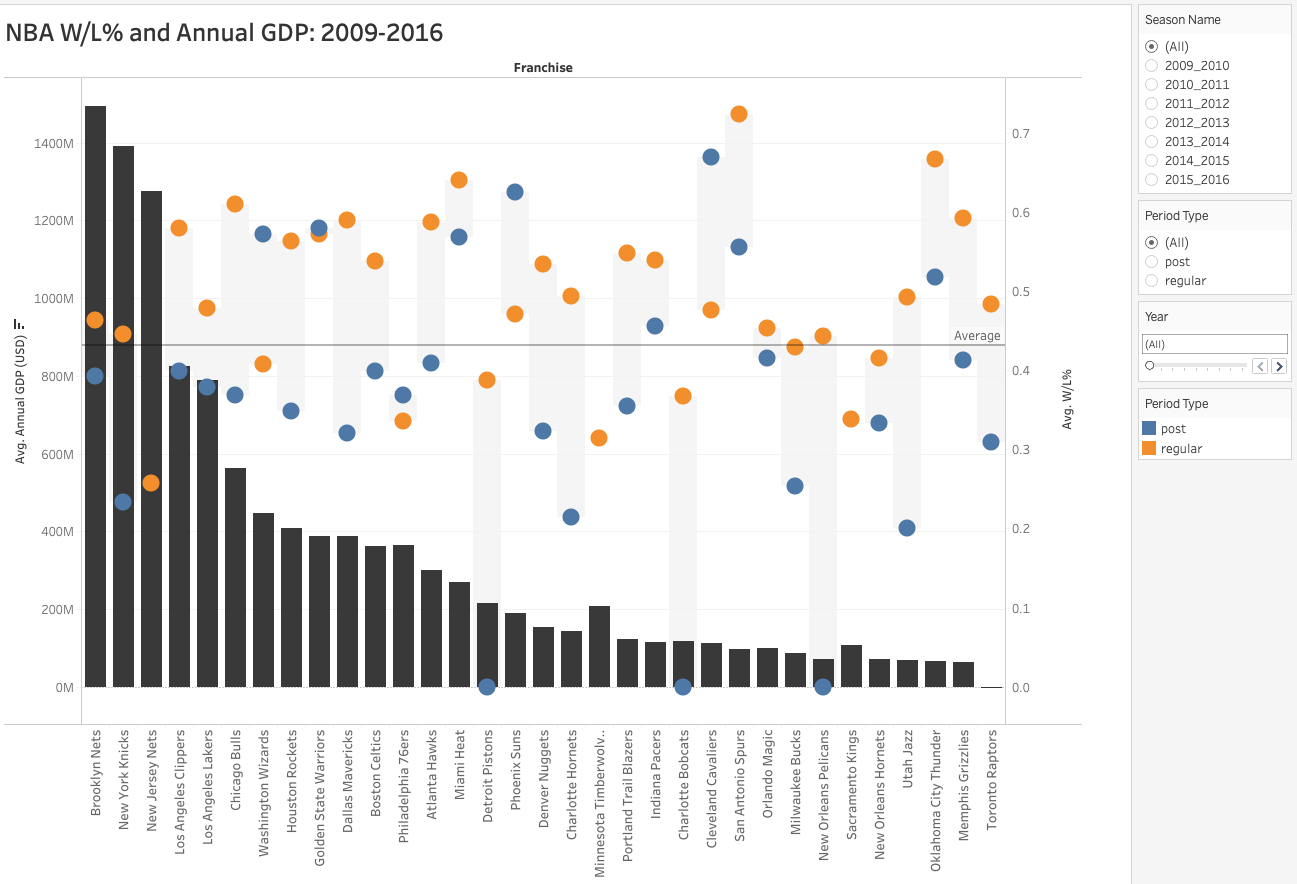

In this visualization, each black bar represents the average GDP of the metro area where each franchise is located from 2009-2016. Each orange dot represents a franchise's average regular season W/L% from 2009-2015. Each blue dot represents a franchise's average regular season W/L% from 2010-2016. The light grey lines connect the pairs of dots for each team. The average reference line shows ths overall average W/L% across all teams and play periods.

Since the results are averaged and represent 2009-2016, there are some differences in the GDP values of teams within the same metro area (NYC metro area teams and LA metro area teams). This is because teams with more postseason appearances have their city GDP counted in both the regular season and postseason.

### Overall Results - Data Insights

Overall, this chart indicates that there is not a significant relationship between a metro area's GDP and the performance of its NBA team. However, there individual cases that are of interest. 

First, although the New York area has the largest average GDP, the three teams associated with this metro area have underperformed against the overall average. For the Nets and Knicks, their regular season performances are close to average and their postseason performances are below average. The Nets did not have a postseason appearance and their average regular season W/L% was the lowest for all teams. On the other hand, the San Antonio Spurs, Oklahoma City Thunder, and Cleveland Cavaliers have significantly outperformed given their comparatively smaller metro area GDP. 

Second, this chart shows that most teams have an average postseason W/L% that is lower than their average regular season W/L%. The only teams with a higher postseason W/L% were the Washington Wizards, Golden State Warriors, Philadelphia 76ers, Phoenix Suns and Cleveland Cavaliers. The Warriors and Cavaliers each have two Finals appearances during this time period, however, the Wizards and 76ers did not appear in a Finals during this time period. In general, this suggests that regular season W/L% is a better indicator of potential postseason success. 

## Overall Average W/L% by Franchise

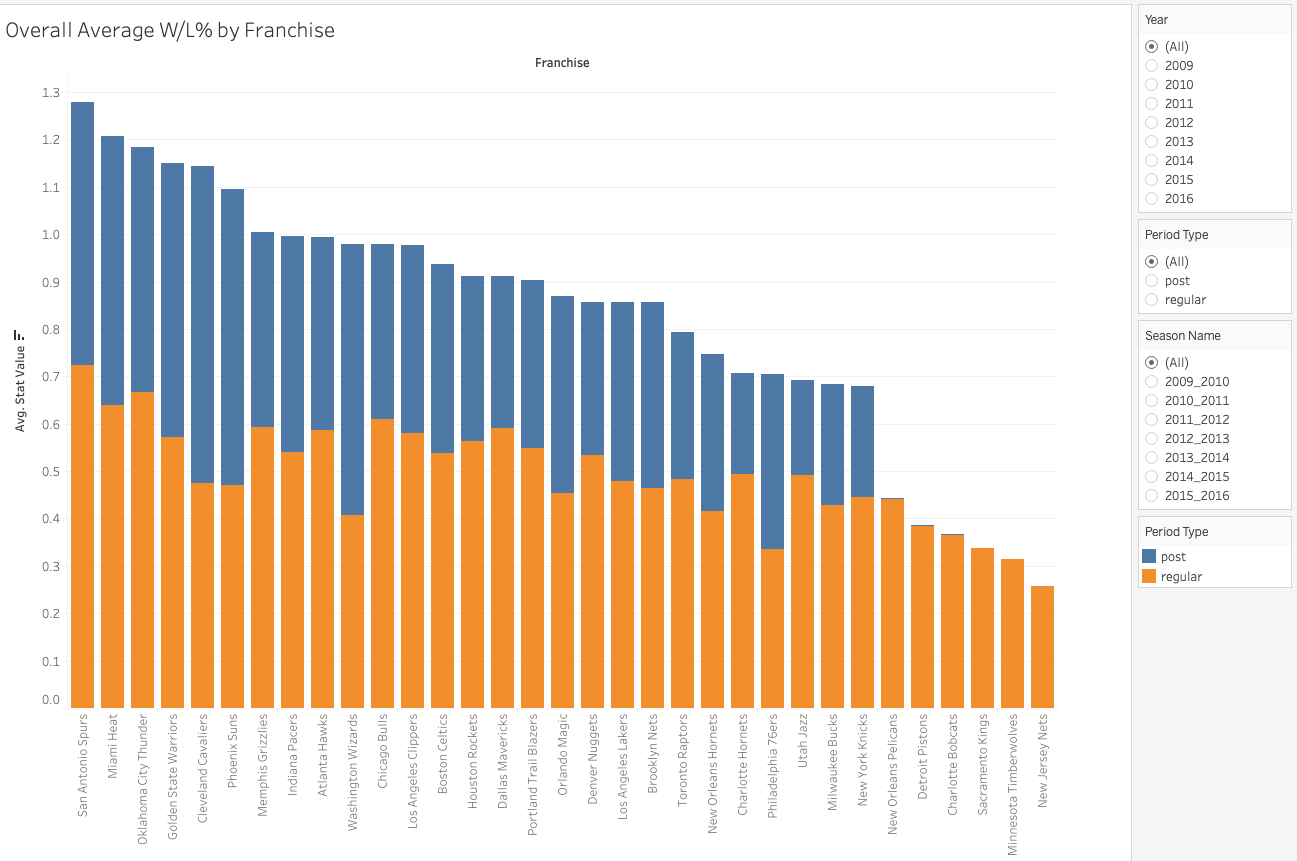

This stacked bar chart shows the overall average W/L%s for all franchises in all years. Postseason W/L% is shown in blue, and regular season W/L% is shown in orange. Overall, this chart indicates that the San Antonion Spurs, Miami Heat, Oklahoma City Thunder, Golden State Warriors, and Cleveland Cavaliers were the most successful teams during this time perid. In these areas, only San Francisco and Miami have a metro area GDP higher than the overall average.

## Simple Linear Regression Analysis

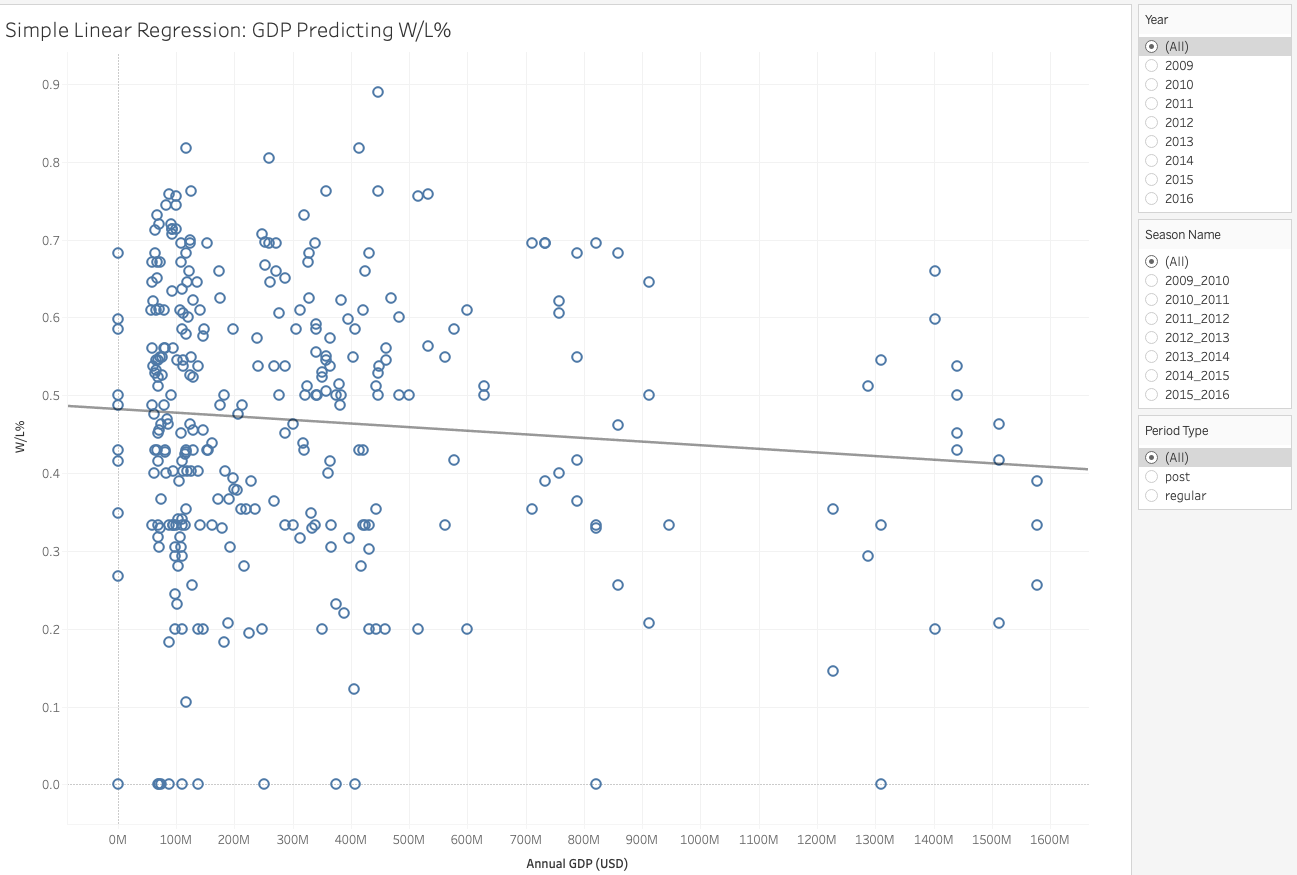

Finally, I ran a simple linear regression analysis to look at the relationship between annual GDP and W/L% on a more mathematical level. Each dot on the scatterplot is the annual GDP value for a given metro area within a given year. You can see that most annual GDPs are around $100M and that most W/L%s are between 0.4 and 0.6.

The trendline on this chart indicates that from 2009-2016, annual GDP was not a significant predictor of W/L%. The p-value was not significant (.107028) and the r-squared value (0.0080971) indicates that relationship between annual GDP and W/L% only explains approximately 0.81% of the variance in the data. Therefore, we can mathematically conclude that there is no causal relationship between a metro area's annual GDP and the performance of its NBA team.